# **Projet NLP: Classification AI and Human Texts**

<ins>Group :</ins>
- Thomas Sinapi
- Pierre Derathe
- Manitas Bahri

[Link to the database](https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import nltk
import numpy as np
import optuna
import pandas as pd
import re

from collections import Counter
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from wordcloud import WordCloud

# import torch
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [2]:
df = pd.read_csv("data/data.csv")
X, y = df["text"], df["generated"].astype("int")
df.shape

(4000, 2)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

X_train.shape, X_test.shape, X_val.shape

((2800,), (600,), (600,))

## 0. **<ins> Utils functions </ins>**

In [4]:
# nltk.download("stopwords")

In [5]:
def get_vector_w2v(text, model):
    """
    Get the vector representation of a text using Word2Vec model

    Args:
        text: list of words
        model: Word2Vec model

    Returns:
        vector: vector representation of the text
    """
    vector = [0] * model.vector_size
    count = 0
    
    for word in text:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    
    if count != 0:
        vector = [x / count for x in vector]
    
    return vector

In [6]:
def remove_stopwords(tokens_list):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = np.empty_like(tokens_list)
    
    for i, tokens in enumerate(tokens_list):
        filtered_tokens[i] = [word for word in tokens if word not in stop_words]
    
    return pd.Series(filtered_tokens)

## 1. **<ins>Preprocessing</ins>**

In [7]:
X_train = X_train.to_frame()
X_test = X_test.to_frame()
X_val = X_val.to_frame()

In [8]:
# Count the number of special characters with regex
X_train["n_ponct"] = X_train["text"].str.count(r"\W")
X_test["n_ponct"] = X_test["text"].str.count(r"\W")
X_val["n_ponct"] = X_val["text"].str.count(r"\W")

# Count the number uppercase characters
X_train["n_upper"] = X_train["text"].str.count(r"[A-Z]")
X_test["n_upper"] = X_test["text"].str.count(r"[A-Z]")
X_val["n_upper"] = X_val["text"].str.count(r"[A-Z]")

# Count the number of stopwords
X_train["n_stopword"] = X_train["text"].apply(lambda x: len([word for word in x.split() if word in (stopwords.words('english'))]))
X_test["n_stopword"] = X_test["text"].apply(lambda x: len([word for word in x.split() if word in (stopwords.words('english'))]))
X_val["n_stopword"] = X_val["text"].apply(lambda x: len([word for word in x.split() if word in (stopwords.words('english'))]))

# Normalize the data
scaler = MinMaxScaler()

X_train[["n_ponct", "n_upper", "n_stopword"]] = scaler.fit_transform(X_train[["n_ponct", "n_upper", "n_stopword"]])
X_test[["n_ponct", "n_upper", "n_stopword"]] = scaler.transform(X_test[["n_ponct", "n_upper", "n_stopword"]])
X_val[["n_ponct", "n_upper", "n_stopword"]] = scaler.transform(X_val[["n_ponct", "n_upper", "n_stopword"]])

### 1.1 **Simple Preprocessing**

In [9]:
tokenizer = RegexpTokenizer(r'\w+')

# Tokenize the X_train
X_train_tok = X_train["text"].map(lambda x: tokenizer.tokenize(x.lower()))
X_train_tok = remove_stopwords(X_train_tok)

# Tokenize the X_test
X_test_tok = X_test["text"].map(lambda x: tokenizer.tokenize(x.lower()))
X_test_tok = remove_stopwords(X_test_tok)

# Tokenize the X_val
X_val_tok = X_val["text"].map(lambda x: tokenizer.tokenize(x.lower()))
X_val_tok = remove_stopwords(X_val_tok)

In [10]:
# Clean data
X_train_clean = X_train_tok.str.join(" ")
X_test_clean = X_test_tok.str.join(" ")
X_val_clean = X_val_tok.str.join(" ")

### 1.2 **Compute Statistics**

### 1.2 **TF-IDF**

In [11]:
tfidf = TfidfVectorizer()

# Apply the vectorizer to data
X_train_tfidf = tfidf.fit_transform(X_train_clean)
X_test_tfidf = tfidf.transform(X_test_clean)
X_val_tfidf = tfidf.transform(X_val_clean)

mms_tfidf = MinMaxScaler()

# Rescale the data to 0-1 (for multinomial nb model)
X_train_tfidf = mms_tfidf.fit_transform(X_train_tfidf.toarray())
X_test_tfidf = mms_tfidf.transform(X_test_tfidf.toarray())
X_val_tfidf = mms_tfidf.transform(X_val_tfidf.toarray())

print("Number of words in vocabulary:", X_train_tfidf.shape[1])

Number of words in vocabulary: 18820


In [12]:
X_train_tfidf = X_train.drop(columns=["text"]).join(pd.DataFrame(X_train_tfidf, columns=tfidf.get_feature_names_out()))
X_test_tfidf = X_test.drop(columns=["text"]).join(pd.DataFrame(X_test_tfidf, columns=tfidf.get_feature_names_out()))
X_val_tfidf = X_val.drop(columns=["text"]).join(pd.DataFrame(X_val_tfidf, columns=tfidf.get_feature_names_out()))

In [13]:
# Print features used in the TF-IDF vectorizer
pprint(tfidf.get_feature_names_out()[1000:1050])

array(['albeit', 'alcohol', 'alcoholic', 'aledged', 'alenhon', 'alergic',
       'alert', 'alertness', 'alerts', 'alex', 'alexa', 'alexander',
       'alfred', 'algorethanks', 'algorithm', 'algorithms', 'alien',
       'alienaite', 'alienate', 'alienated', 'alienating', 'alienation',
       'aliens', 'align', 'aligned', 'alignment', 'aligns', 'alihough',
       'alike', 'alio', 'aliso', 'alittle', 'alive', 'allaround',
       'allays', 'alleged', 'allegedly', 'allen', 'allergic', 'allergies',
       'alleviate', 'alleviated', 'alleviates', 'alleviating',
       'alleviation', 'alliance', 'allocate', 'allocated', 'allocates',
       'allocating'], dtype=object)


### 1.3 **Word2Vec**

In [14]:
w2v = Word2Vec(X_train_tok, vector_size=100, window=5, min_count=1, workers=-1)

# Get the vector representation of word2vec
X_train_w2v_not_scale = X_train_tok.map(lambda x: get_vector_w2v(x, w2v))
X_test_w2v_not_scale = X_test_tok.map(lambda x: get_vector_w2v(x, w2v))
X_val_w2v_not_scale = X_val_tok.map(lambda x: get_vector_w2v(x, w2v))

mms_w2v = MinMaxScaler()

# Rescale the data to 0-1 (for multinomial nb model)
X_train_w2v = mms_w2v.fit_transform(X_train_w2v_not_scale.tolist())
X_test_w2v = mms_w2v.transform(X_test_w2v_not_scale.tolist())
X_val_w2v = mms_w2v.transform(X_val_w2v_not_scale.tolist())

In [15]:
# Join the data with the vector representation
X_train_w2v = X_train.drop(columns=["text"]).join(pd.DataFrame(X_train_w2v))
X_test_w2v = X_test.drop(columns=["text"]).join(pd.DataFrame(X_test_w2v))
X_val_w2v = X_val.drop(columns=["text"]).join(pd.DataFrame(X_val_w2v))

## 2. **<ins>Data Visualization</ins>**

In [16]:
print("Human Text")
pprint(X[y == 0].iloc[0])

Human Text
('Cars. Cars have been around since they became famous in the 1900s, when '
 'Henry Ford created and built the first ModelT. Cars have played a major role '
 'in our every day lives since then. But now, people are starting to question '
 'if limiting car usage would be a good thing. To me, limiting the use of cars '
 'might be a good thing to do.\n'
 '\n'
 'In like matter of this, article, "In German Suburb, Life Goes On Without '
 'Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of '
 'suburbs, where middle class families from either Shanghai or Chicago tend to '
 'make their homes. Experts say how this is a huge impediment to current '
 'efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are '
 'responsible for 12 percent of greenhouse gas emissions in Europe...and up to '
 '50 percent in some carintensive areas in the United States. Cars are the '
 'main reason for the greenhouse gas emissions because of a lot of people '
 'dri

In [17]:
print("AI Text")
pprint(X[y == 1].iloc[0])

AI Text
('This essay will analyze, discuss and prove one reason in favor of keeping '
 'the Electoral College in the United States for its presidential elections. '
 'One of the reasons to keep the electoral college is that it is better for '
 'smaller, more rural states to have more influence as opposed to larger '
 'metropolitan areas that have large populations. The electors from these '
 'states are granted two votes each. Those from larger, more populated areas '
 'are granted just one vote each. Smaller states tend to hold significant '
 'power because their two votes for president and vice president add up more '
 'than the votes of larger states that have many electors. This is because of '
 'the split of the electoral votes. Some argue that electors are not bound to '
 'vote for the candidate who won the most votes nationally. They do not have '
 "to vote for their own state's nominee unless their state has a winner take "
 'all system. However, there are states that have adop

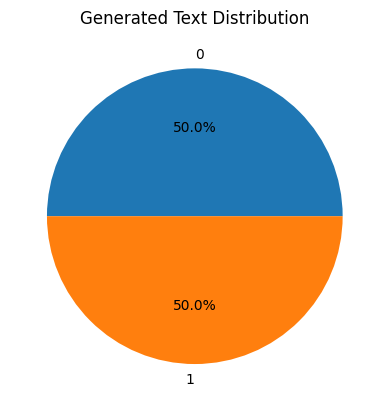

In [18]:
# Plot the distribution of the generated text
plt.pie(y.value_counts(), labels=y.value_counts().index, autopct='%1.1f%%')
plt.title("Generated Text Distribution")
plt.show()

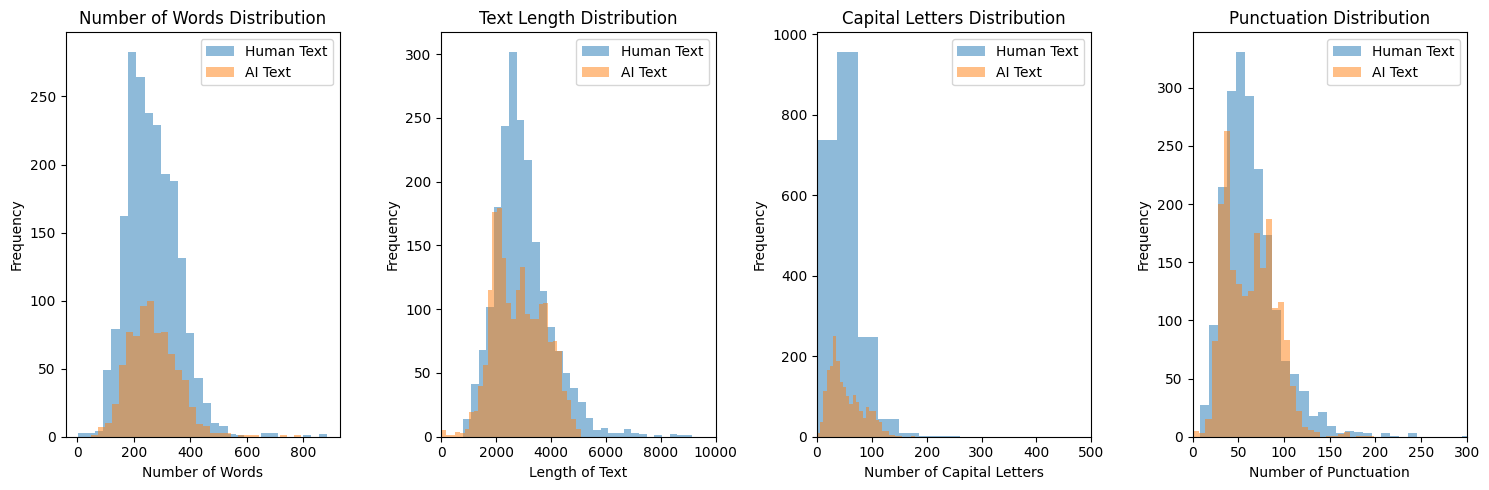

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

# Plot the distribution of the number of words by class
ax[0].hist(X_train_tok[y == 0].str.len(), bins=30, alpha=0.5, label="Human Text")
ax[0].hist(X_train_tok[y == 1].str.len(), bins=30, alpha=0.5, label="AI Text")
ax[0].set_title("Number of Words Distribution")
ax[0].set_xlabel("Number of Words")
ax[0].set_ylabel("Frequency")
ax[0].legend()
# ax[0].set_xlim(0, 1000)

# Plot the distribution of the text length by class
ax[1].hist(X[y == 0].str.len(), bins=30, alpha=0.5, label="Human Text")
ax[1].hist(X[y == 1].str.len(), bins=30, alpha=0.5, label="AI Text")
ax[1].set_title("Text Length Distribution")
ax[1].set_xlabel("Length of Text")
ax[1].set_ylabel("Frequency")
ax[1].legend()
ax[1].set_xlim(0, 10000)

# Plot the distribution of the capital letters by class
count_upper_g = X.str.findall(r"[A-Z]").str.len().groupby(y)
ax[2].hist(count_upper_g.get_group(0), bins=30, alpha=0.5, label="Human Text")
ax[2].hist(count_upper_g.get_group(1), bins=30, alpha=0.5, label="AI Text")
ax[2].set_title("Capital Letters Distribution")
ax[2].set_xlabel("Number of Capital Letters")
ax[2].set_ylabel("Frequency")
ax[2].legend()
ax[2].set_xlim(0, 500)

# Plot the distribution of the punctuation by class
count_punct_g = X.str.findall(r"[^\w\s]").str.len().groupby(y)
ax[3].hist(count_punct_g.get_group(0), bins=30, alpha=0.5, label="Human Text")
ax[3].hist(count_punct_g.get_group(1), bins=30, alpha=0.5, label="AI Text")
ax[3].set_title("Punctuation Distribution")
ax[3].set_xlabel("Number of Punctuation")
ax[3].set_ylabel("Frequency")
ax[3].legend()
ax[3].set_xlim(0, 300)

plt.tight_layout()
plt.show()

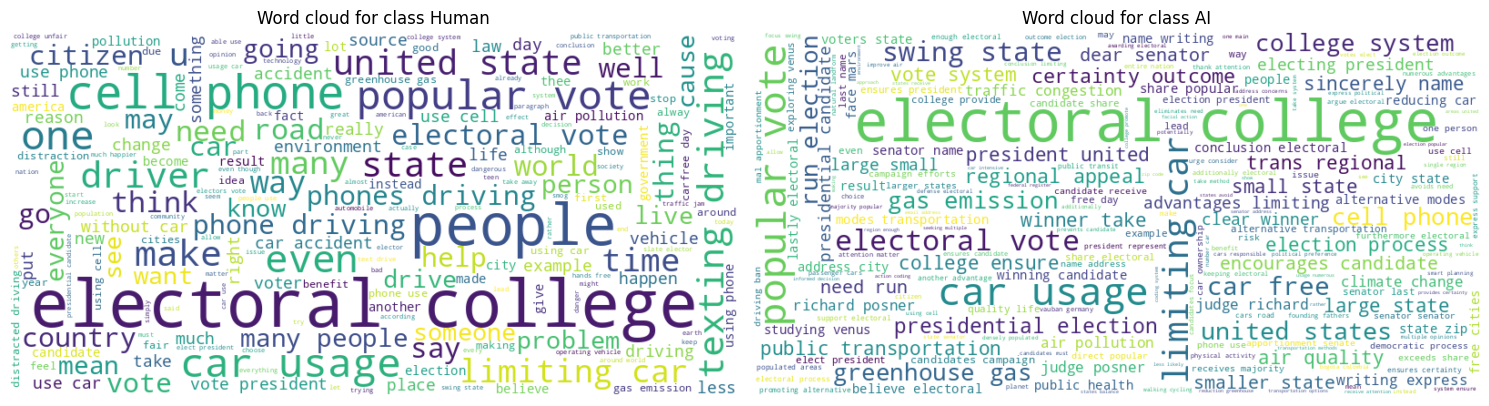

In [20]:
class_0_text = " ".join(X_train_clean[y_train == 0])
class_1_text = " ".join(X_train_clean[y_train == 1])

plt.figure(figsize=(15, 7))

# Word cloud for the class Human
plt.subplot(1, 2, 1)
wordcloud_0 = WordCloud(width=800, height=400, background_color="white").generate(class_0_text)
plt.imshow(wordcloud_0, interpolation="bilinear")
plt.title("Word cloud for class Human")
plt.axis("off")

# Word cloud for the class AI
plt.subplot(1, 2, 2)
wordcloud_1 = WordCloud(width=800, height=400, background_color="white").generate(class_1_text)
plt.imshow(wordcloud_1, interpolation="bilinear")
plt.title("Word cloud for class AI")
plt.axis("off")

plt.tight_layout()
plt.show()


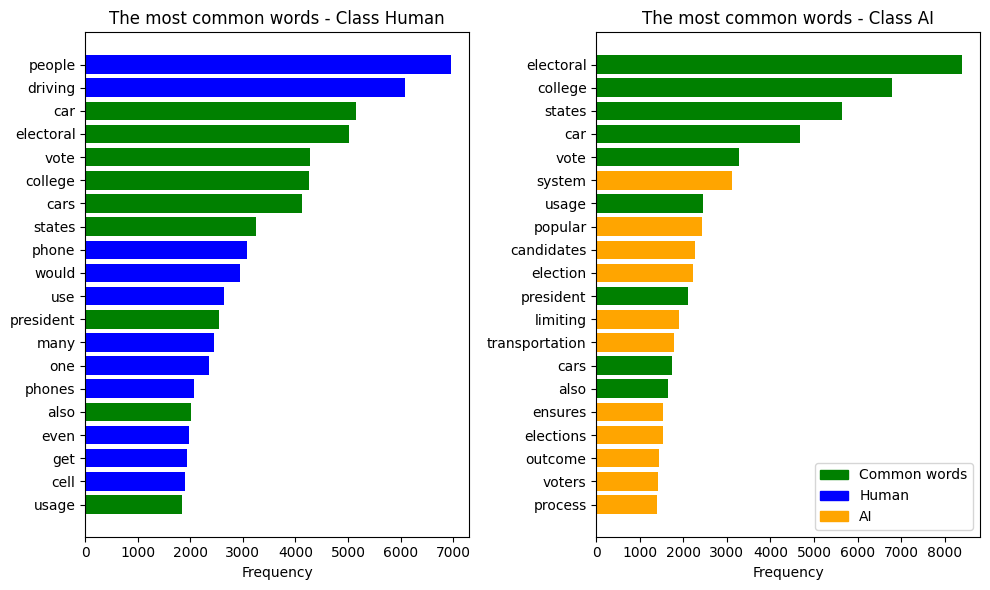

In [21]:
class_0_tokens = " ".join(X_train_clean[y_train == 0]).split()
class_1_tokens = " ".join(X_train_clean[y_train == 1]).split()

top_n = 20
class_0_word_freq = Counter(class_0_tokens).most_common(top_n)
class_1_word_freq = Counter(class_1_tokens).most_common(top_n)

# Get the common words between the two classes
common_words = set([word[0] for word in class_0_word_freq]).intersection([word[0] for word in class_1_word_freq])

# Plot the most common words
plt.figure(figsize=(10, 6))

# Human class
plt.subplot(1, 2, 1)

for i, word in enumerate([freq[0] for freq in class_0_word_freq]):
    color = "green" if word in common_words else "blue"
    plt.barh(top_n - i - 1, class_0_word_freq[i][1], color=color)

plt.yticks(range(top_n), [freq[0] for freq in class_0_word_freq][::-1])
plt.xlabel("Frequency")
plt.title("The most common words - Class Human")

# AI class
plt.subplot(1, 2, 2)
for i, word in enumerate([freq[0] for freq in class_1_word_freq]):
    color = "green" if word in common_words else "orange"
    plt.barh(top_n - i - 1, class_1_word_freq[i][1], color=color)
plt.yticks(range(top_n), [freq[0] for freq in class_1_word_freq][::-1])

plt.xlabel("Frequency")
plt.title("The most common words - Class AI")

# Add legend
l1 = mpatches.Patch(color="green", label="Common words")
l2 = mpatches.Patch(color="blue", label="Human")
l3 = mpatches.Patch(color="orange", label="AI")
plt.legend(handles=[l1, l2, l3], loc="lower right")

plt.tight_layout()
plt.show()


## 3. **<ins>Base Model</ins>**

In [22]:
def objective(trial):
    """
    Objective function for the Optuna optimization

    Args:
        trial: Optuna trial object

    Returns:
        score: accuracy score of the model
    """
    # Random Forest hyperparameters
    trial.suggest_int("n_estimators", 50, 150)

    # Fine-tune depth parameters
    trial.suggest_int("max_depth", 3, 40)
    trial.suggest_int("min_samples_split", 2, 40)
    trial.suggest_int("min_samples_leaf", 1, 20)
    
    # Define the Random Forest model
    rf = RandomForestClassifier(**trial.params, random_state=0, n_jobs=-1)

    return cross_val_score(rf, X_train_w2v.values, y_train, cv=5, scoring="accuracy").mean()

In [23]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print(study.best_params, study.best_value)

[I 2024-02-29 22:15:52,419] A new study created in memory with name: no-name-b98429ff-e01d-4f3a-9412-fcf91f17d69f
[I 2024-02-29 22:15:54,483] Trial 0 finished with value: 0.9417857142857142 and parameters: {'n_estimators': 76, 'max_depth': 5, 'min_samples_split': 30, 'min_samples_leaf': 16}. Best is trial 0 with value: 0.9417857142857142.
[I 2024-02-29 22:15:55,882] Trial 1 finished with value: 0.9439285714285715 and parameters: {'n_estimators': 51, 'max_depth': 7, 'min_samples_split': 39, 'min_samples_leaf': 20}. Best is trial 1 with value: 0.9439285714285715.
[I 2024-02-29 22:15:58,687] Trial 2 finished with value: 0.9492857142857144 and parameters: {'n_estimators': 109, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 17}. Best is trial 2 with value: 0.9492857142857144.
[I 2024-02-29 22:16:01,261] Trial 3 finished with value: 0.9525 and parameters: {'n_estimators': 97, 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 16}. Best is trial 3 with value: 0.9525.


{'n_estimators': 132, 'max_depth': 31, 'min_samples_split': 9, 'min_samples_leaf': 1} 0.9650000000000001


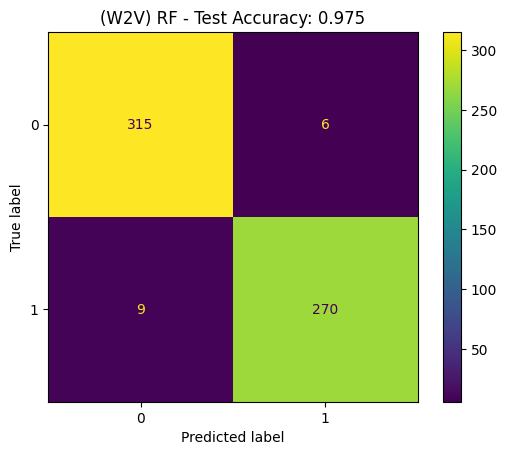

In [24]:
# Train the Random Forest model
rf = RandomForestClassifier(**study.best_params, random_state=0, n_jobs=-1)

rf.fit(X_train_w2v.values, y_train)

# Predict the test set
y_test_pred = rf.predict(X_test_w2v.values)

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.title(f"(W2V) RF - Test Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
plt.show()

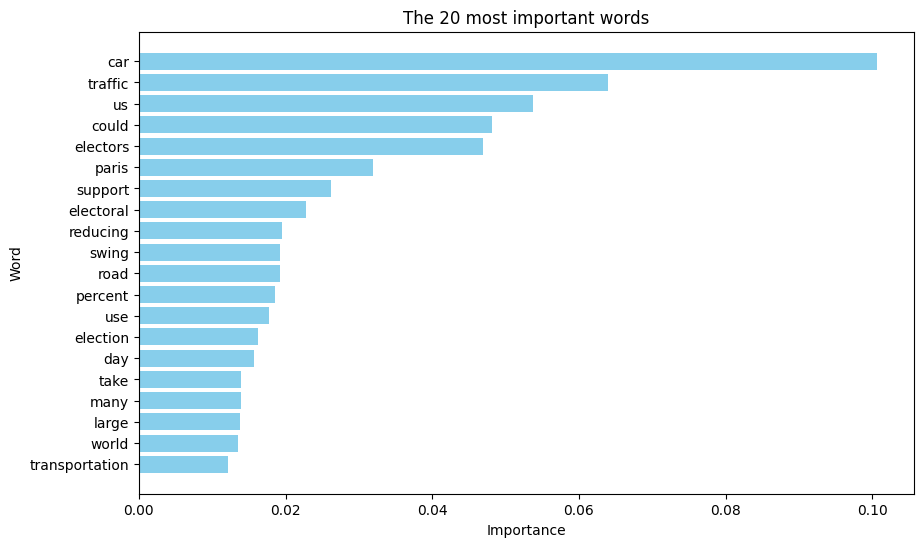

In [25]:
feature_importances = rf.feature_importances_
important_words = [w2v.wv.index_to_key[i] for i in feature_importances.argsort()[::-1]][:20]
importances = [feature_importances[w2v.wv.key_to_index[word]] for word in important_words]

plt.figure(figsize=(10, 6))
plt.barh(important_words, importances, color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Word")
plt.title("The 20 most important words")
plt.gca().invert_yaxis()
plt.show()


## 4. **<ins>Comparison of different models</ins>**

Comparative studies of Random Forest and Multinomial NB models using TF-IDF and Word2Vec data.

### 4.1 **Random Forest (TF-IDF)**

In [26]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
y_cv = cross_val_predict(rf, X_train_tfidf.values, y_train, cv=5)

rf.fit(X_train_tfidf.values, y_train)
y_pred = rf.predict(X_test_tfidf.values)

print(f"(TF-IDF) RF - Cross Validation Accuracy: {accuracy_score(y_train, y_cv):.3f}")

(TF-IDF) RF - Cross Validation Accuracy: 0.989


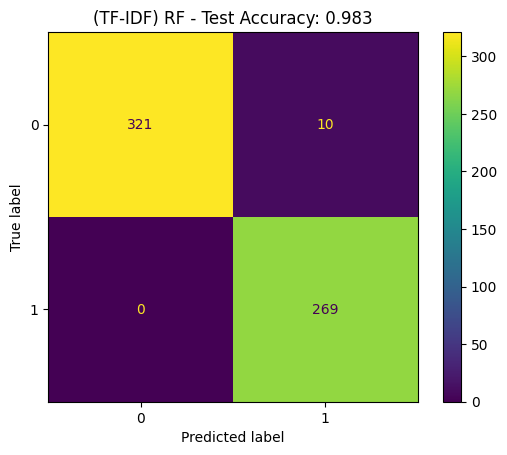

In [27]:
ConfusionMatrixDisplay.from_predictions(y_pred, y_test)
plt.title(f"(TF-IDF) RF - Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
plt.show()

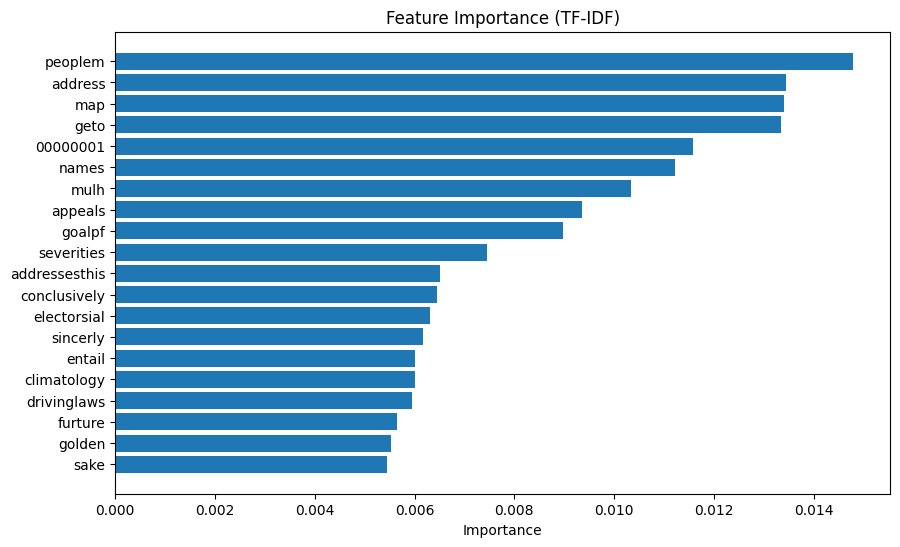

In [28]:
feature_importance = rf.feature_importances_
feature_names = tfidf.get_feature_names_out()
sorted_idx = feature_importance.argsort()[-20:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Importance")
plt.title("Feature Importance (TF-IDF)")
plt.show()

### 4.2 **Multinomial Naive Bayes (TF-IDF)**

In [29]:
mb = MultinomialNB()
y_cv = cross_val_predict(mb, X_train_tfidf.values, y_train, cv=5)

mb.fit(X_train_tfidf, y_train)
y_pred = mb.predict(X_test_tfidf)

print(f"(TF-IDF) Multinomial NB - Cross Validation Accuracy: {accuracy_score(y_train, y_cv):.3f}")

(TF-IDF) Multinomial NB - Cross Validation Accuracy: 0.968


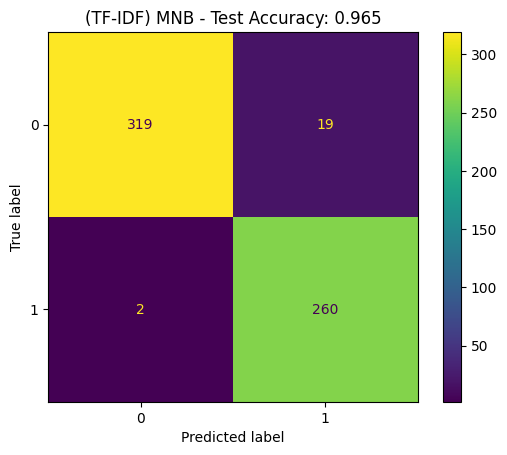

In [30]:
ConfusionMatrixDisplay.from_predictions(y_pred, y_test)
plt.title(f"(TF-IDF) MNB - Test Accuracy: {accuracy_score(y_test, y_pred)}")
plt.show()

### 4.3 **Multinomial Naive Bayes (Word2Vec)**

In [31]:
mb = MultinomialNB()
y_cv = cross_val_predict(mb, X_train_w2v.values, y_train, cv=5)

mb.fit(X_train_w2v.values, y_train)
y_pred = mb.predict(X_test_w2v.values)

print(f"(Word2Vec) Multinomial NB - Cross Validation Accuracy: {accuracy_score(y_train, y_cv):.3f}")

(Word2Vec) Multinomial NB - Cross Validation Accuracy: 0.873


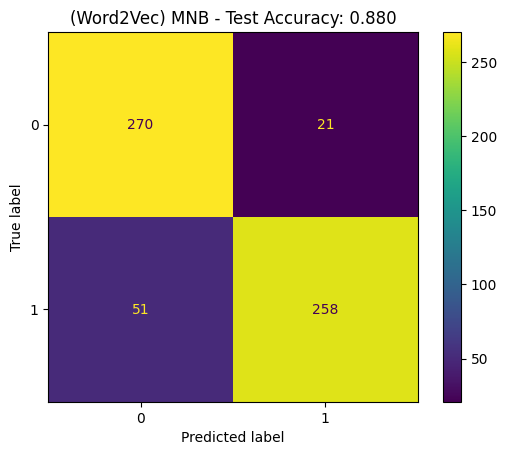

In [32]:
ConfusionMatrixDisplay.from_predictions(y_pred, y_test)
plt.title(f"(Word2Vec) MNB - Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
plt.show()

## 5. **<ins>Pretrained Model</ins>**

We encountered memory issues that prevented the successful execution of the BERT code.

In [33]:
# Load the pre-trained BERT model and tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


In [34]:
# Preprocess data for BERT
# X_train_bert = tokenizer(X_train_clean.tolist(), padding=True, truncation=True, return_tensors="pt")
# X_test_bert = tokenizer(X_test_clean.tolist(), padding=True, truncation=True, return_tensors="pt")

# y_train_bert = torch.tensor(y_train.values)
# y_test_bert = torch.tensor(y_test.values)

In [35]:
# Train the BERT model
# optimizer = AdamW(model.parameters(), lr=1e-5)
# epochs = 3

# for epoch in range(epochs):
#     model.train()
#     optimizer.zero_grad()
#     outputs = model(**X_train_bert, labels=y_train_bert)
#     loss = outputs.loss
#     loss.backward()
#     optimizer.step()

In [36]:
# Evaluate the BERT model
# model.eval()
# with torch.no_grad():
#     val_outputs = model(**X_test_bert, labels=y_test_bert)
#     val_loss = val_outputs.loss
#     val_predictions = torch.argmax(val_outputs.logits, axis=1)
#     val_accuracy = (val_predictions == y_test_bert).float().mean().item()

In [37]:
# print(f"BERT - Validation Accuracy: {val_accuracy:.3f}")

## 6. **<ins>Conclusion</ins>**

### 6.1 **Results of Validation set**

In [38]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
rf.fit(X_train_tfidf.values, y_train)

y_pred_train = rf.predict(X_train_tfidf.values)
y_pred_val = rf.predict(X_val_tfidf.values)
print(f"TF-IDF - Random Forest - Training Accuracy: {accuracy_score(y_train, y_pred_train):.3f}")
print(f"TF-IDF - Random Forest - Validation Accuracy: {accuracy_score(y_val, y_pred_val):.3f}")

TF-IDF - Random Forest - Training Accuracy: 1.000
TF-IDF - Random Forest - Validation Accuracy: 0.985


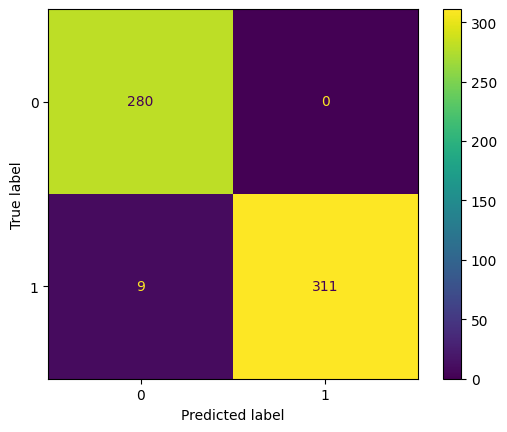

In [39]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val)
plt.show()

### 6.2 **Example with ChatGPT text**

In [40]:
chat_gpt = """
Recent studies suggest that regular exercise not only improves physical health but also has a positive impact
on mental well-being. Engaging in physical activities such as jogging, swimming, or yoga can reduce stress levels, 
boost mood, and increase overall happiness. Furthermore, exercise has been linked to better cognitive function and 
lower risk of developing certain chronic diseases. It's clear that making exercise a part of your routine can lead 
to a healthier and happier life.
"""
n_ponct = len(re.findall(r"\W", chat_gpt))
n_upper = len(re.findall(r"[A-Z]", chat_gpt))
n_stopword = len([word for word in chat_gpt.split() if word in (stopwords.words('english'))])
stat = scaler.transform([[n_ponct, n_upper, n_stopword]]).tolist()[0]

# Apply preprocessing to the chat_gpt text
chat_gpt_tok = tokenizer.tokenize(chat_gpt.lower())
chat_gpt_tok = [word for word in chat_gpt_tok if word not in stopwords.words('english')]
chat_gpt_tfidf = tfidf.transform([" ".join(chat_gpt_tok)])
chat_gpt_tfidf = mms_tfidf.transform(chat_gpt_tfidf.toarray())
chat_gpt_tfidf = stat + chat_gpt_tfidf.tolist()[0]

# Predict the class of the chat_gpt text
y_pred_chat_gpt = rf.predict([chat_gpt_tfidf])
class_pred = "AI" if y_pred_chat_gpt[0] else "Human"
print("Predicted class: ", class_pred)

Predicted class:  AI


/home/manitas/.local/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
